# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you 
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_path`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit an **archive file of the directory** whose name is stored in `model_path`, which 
contains your trained model.
    - use `saveModel` to put your final, trained model in this directory
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the directory whose name is stored in `model_path`
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


In [20]:
# importing libraries

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

## Have a look at the data

In [21]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "AAPL.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file), index_col = 'Dt' )

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4277, 8)


In [22]:
data.head()

,Adj Close,Close,Div,Factor,High,Low,Open,Volume
Dt,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0
2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0
2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0
2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0
2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0


## Calculate the return of AAPL

### Note: since we do not want to predict future return with future data, we shift the t-th return to day t-1 because it is predicted by the relevant data in day t-1.

In [23]:
data['Return']=data['Close'].pct_change()
data['Return'] = data['Return'].shift(-1)
data

,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Return
Dt,,,,,,,,,
2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0,-0.084315
2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0,0.014634
2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0,-0.086538
2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0,0.047368
2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0,-0.017588
...,...,...,...,...,...,...,...,...,...
2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,0.006351
2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,-0.004264
2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,-0.000257


## Get more indexes relevant to stock market

### TALIB is widely used by trading software developers requiring to perform technical analysis of financial market data.

In [24]:
# We calculate some general indexes. 
import talib as ta

data['ATR_3'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=3)
data['ATR_5'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=5)
data['ATR_10'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=10)
data['RSI'] = ta.RSI(data['Close'])
data['MACD_3'] = ta.MA(data['Close'],timeperiod=3)/data['Close']
data['MACD_5'] = ta.MA(data['Close'],timeperiod=5)/data['Close']
data['MACD_10'] = ta.MA(data['Close'],timeperiod=10)/data['Close']
data['SMA'] = ta.SMA(data['Close'])/data['Close']
data['MIDPOINT']=ta.MIDPOINT(data['Close'])/data['Close']
data['MIDPRICE']=ta.MIDPRICE(data['High'],data['Low'])/data['Close']
data['SAR']=ta.SAR(data['High'],data['Low'])
data['SAREXT']=ta.SAREXT(data['High'],data['Low'])
data['upper'], data['middle'], data['lower'] = ta.BBANDS(data['Close'])

In [25]:
# Rename the column Adj Close because space cannot be recognized in OLS regression process. 
data=data.rename(columns={'Adj Close':'Adj'})
data.describe()

,Adj,Close,Div,Factor,High,Low,Open,Volume,Return,ATR_3,...,MACD_5,MACD_10,SMA,MIDPOINT,MIDPRICE,SAR,SAREXT,upper,middle,lower
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03,4276.000000,4274.000000,...,4273.000000,4268.000000,4248.000000,4264.000000,4264.000000,4276.000000,4276.000000,4273.000000,4273.000000,4273.000000
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08,0.000714,4.569216,...,1.002809,1.006360,1.020975,1.009778,1.008722,171.326978,18.895706,176.220605,170.505889,164.791173
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07,0.031476,5.639803,...,0.105894,0.163689,0.293874,0.183027,0.184630,173.596259,243.183736,178.839580,173.343185,169.227383
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.854857,0.333772,...,0.861146,0.828057,0.773289,0.857525,0.855065,12.720000,-705.070000,13.579065,13.280000,-237.703987
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07,-0.011358,1.366432,...,0.983607,0.972255,0.941381,0.963726,0.961994,39.793910,-95.770618,41.336901,39.506000,37.140372
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08,0.000734,2.832341,...,0.997734,0.994617,0.985944,0.989556,0.988630,106.083766,19.291603,110.137009,107.004000,102.910110
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08,0.013783,6.499379,...,1.012497,1.019706,1.030878,1.024231,1.023378,221.678887,112.963988,226.938562,223.862000,209.584005
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,0.139050,190.512147,...,5.696862,6.206670,6.311367,4.085235,4.106391,705.070000,675.288080,973.942860,700.517200,697.914493


## Get more sectors informaiton

### Since there are indexes for different sectors including technology, energy, finance, and so on, we calculate the return of those sectors. They may not be effective and significantly related to AAPL return, we will find out later. 

In [26]:
sp500 = pd.read_csv( os.path.join(DATA_DIR, "train", "SPY.csv"), index_col = 'Dt' )
sp500['Return']=sp500['Close'].pct_change()
sp500['Return'] = sp500['Return'].shift(-1)
sp500 = sp500.rename(columns={'Return':'Sp500'})

energy = pd.read_csv(os.path.join(DATA_DIR, "train", "XLE.csv"), index_col = 'Dt' )
energy['Return']=energy['Close'].pct_change()
energy['Return'] = energy['Return'].shift(-1)
energy = energy.rename(columns={'Return':'Energy'})

finance = pd.read_csv(os.path.join(DATA_DIR, "train", "XLF.csv"), index_col = 'Dt' )
finance['Return']=finance['Close'].pct_change()
finance['Return'] = finance['Return'].shift(-1)
finance = finance.rename(columns={'Return':'Finance'})

material = pd.read_csv(os.path.join(DATA_DIR, "train", "XLB.csv"), index_col = 'Dt' )
material['Return']=material['Close'].pct_change()
material['Return'] = material['Return'].shift(-1)
material = material.rename(columns={'Return':'Material'})

industrial = pd.read_csv(os.path.join(DATA_DIR, "train", "XLI.csv"), index_col = 'Dt' )
industrial['Return']=industrial['Close'].pct_change()
industrial['Return'] = industrial['Return'].shift(-1)
industrial = industrial.rename(columns={'Return':'Industrial'})

consumerStaples= pd.read_csv(os.path.join(DATA_DIR, "train", "XLP.csv"), index_col = 'Dt' )
consumerStaples['Return'] = consumerStaples['Close'].pct_change()
consumerStaples['Return'] = consumerStaples['Return'].shift(-1)
consumerStaples = consumerStaples.rename(columns={'Return':'ConsumerStaples'})

tech = pd.read_csv(os.path.join(DATA_DIR, "train", "XLK.csv"), index_col = 'Dt' )
tech['Return'] = tech['Close'].pct_change()
tech['Return'] = tech['Return'].shift(-1)
tech = tech.rename(columns={'Return':'Tech'})

realEstate = pd.read_csv(os.path.join(DATA_DIR, "train", "XLRE.csv"), index_col = 'Dt' )
realEstate['Return'] = realEstate['Close'].pct_change()
realEstate['Return'] = realEstate['Return'].shift(-1)
realEstate = realEstate.rename(columns={'Close':'RealEstate'})

utilities = pd.read_csv(os.path.join(DATA_DIR, "train", "XLU.csv"), index_col = 'Dt' )
utilities['Return'] = utilities['Close'].pct_change()
utilities['Return'] = utilities['Return'].shift(-1)
utilities = utilities.rename(columns={'Return':'Utilities'})

healthCare = pd.read_csv(os.path.join(DATA_DIR, "train", "XLV.csv"), index_col = 'Dt' )
healthCare['Return']=healthCare['Close'].pct_change()
healthCare['Return'] = healthCare['Return'].shift(-1)
healthCare = healthCare.rename(columns={'Return':'HealthCare'})

consumerDiscretionary = pd.read_csv(os.path.join(DATA_DIR, "train", "XLY.csv"), index_col = 'Dt' )
consumerDiscretionary['Return']=consumerDiscretionary['Close'].pct_change()
consumerDiscretionary['Return'] = consumerDiscretionary['Return'].shift(-1)
consumerDiscretionary = consumerDiscretionary.rename(columns={'Return':'ConsumerDiscretionary'})


data = pd.concat([data, sp500['Sp500'], tech['Tech'], energy['Energy'],finance['Finance'],material['Material'],
                 industrial['Industrial'],consumerStaples['ConsumerStaples'],realEstate['RealEstate'],
                 utilities['Utilities'],healthCare['HealthCare'],consumerDiscretionary['ConsumerDiscretionary']], axis=1)
data.describe()

,Adj,Close,Div,Factor,High,Low,Open,Volume,Return,ATR_3,...,Tech,Energy,Finance,Material,Industrial,ConsumerStaples,RealEstate,Utilities,HealthCare,ConsumerDiscretionary
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4.277000e+03,4276.000000,4274.000000,...,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,311.000000,4276.000000,4276.000000,4276.000000
mean,34.065846,170.450354,0.001999,1.001870,172.424040,168.407568,170.528689,1.299660e+08,0.000714,4.569216,...,0.000104,0.000401,0.000154,0.000276,0.000273,0.000237,31.373579,0.000207,0.000259,0.000336
std,36.698987,173.484604,0.031011,0.094251,174.989551,171.934671,173.604272,9.970883e+07,0.031476,5.639803,...,0.016545,0.017706,0.021732,0.015730,0.013665,0.009475,1.528738,0.012124,0.011552,0.014364
min,0.815400,13.120000,0.000000,1.000000,13.190000,12.720000,12.990000,9.835000e+06,-0.854857,0.333772,...,-0.086538,-0.144438,-0.460298,-0.124121,-0.094050,-0.060241,27.220000,-0.085285,-0.097826,-0.116249
25%,3.115300,39.759000,0.000000,1.000000,40.260000,39.030000,39.530000,6.363350e+07,-0.011358,1.366432,...,-0.006996,-0.008367,-0.007206,-0.007547,-0.006149,-0.004710,30.330500,-0.005585,-0.005393,-0.006399
50%,16.948300,106.745000,0.000000,1.000000,108.360000,105.200000,106.959000,1.016484e+08,0.000734,2.832341,...,0.000745,0.000691,0.000421,0.000723,0.000661,0.000442,31.190000,0.000743,0.000395,0.000591
75%,62.413600,222.250000,0.000000,1.000000,224.980000,217.890000,220.010000,1.679636e+08,0.013783,6.499379,...,0.007288,0.009874,0.007935,0.008486,0.007024,0.005261,32.213500,0.006631,0.006288,0.007488
max,122.771400,702.100000,0.570000,7.000000,705.070000,699.570000,702.410000,1.855410e+09,0.139050,190.512147,...,0.161017,0.164747,0.224715,0.140576,0.107052,0.068857,34.790000,0.120730,0.120547,0.097752


## Get other stocks information

### There are stocks like Google, Facebook, and IBM, which are big-name tech companies. They may have relationship with AAPL.

In [27]:
goog = pd.read_csv(os.path.join(DATA_DIR, "train", "GOOG.csv"), index_col = 'Dt' )
goog['Return']=goog['Close'].pct_change()
goog['Return'] = goog['Return'].shift(-1)
goog = goog.rename(columns={'Return':'Goog'})

acn = pd.read_csv(os.path.join(DATA_DIR, "train", "ACN.csv"), index_col = 'Dt' )
acn['Return']=acn['Close'].pct_change()
acn['Return'] = acn['Return'].shift(-1)
acn = acn.rename(columns={'Return':'Acn'})

adbe = pd.read_csv(os.path.join(DATA_DIR, "train", "ADBE.csv"), index_col = 'Dt' )
adbe['Return']=adbe['Close'].pct_change()
adbe['Return'] = adbe['Return'].shift(-1)
adbe = adbe.rename(columns={'Return':'Adbe'})

crm = pd.read_csv(os.path.join(DATA_DIR, "train", "CRM.csv"), index_col = 'Dt' )
crm['Return']=crm['Close'].pct_change()
crm['Return'] = crm['Return'].shift(-1)
crm = crm.rename(columns={'Return':'Crm'})

csco = pd.read_csv(os.path.join(DATA_DIR, "train", "CSCO.csv"), index_col = 'Dt' )
csco['Return']=csco['Close'].pct_change()
csco['Return'] = csco['Return'].shift(-1)
csco = csco.rename(columns={'Return':'Csco'})

fb = pd.read_csv(os.path.join(DATA_DIR, "train", "FB.csv"), index_col = 'Dt' )
fb['Return']=fb['Close'].pct_change()
fb['Return'] = fb['Return'].shift(-1)
fb = fb.rename(columns={'Return':'Fb'})

ibm = pd.read_csv(os.path.join(DATA_DIR, "train", "IBM.csv"), index_col = 'Dt' )
ibm['Return']=ibm['Close'].pct_change()
ibm['Return'] = ibm['Return'].shift(-1)
ibm = ibm.rename(columns={'Return':'Ibm'})

intc = pd.read_csv(os.path.join(DATA_DIR, "train", "INTC.csv"), index_col = 'Dt' )
intc['Return']=intc['Close'].pct_change()
intc['Return'] = intc['Return'].shift(-1)
intc = intc.rename(columns={'Return':'Intc'})

ma = pd.read_csv(os.path.join(DATA_DIR, "train", "MA.csv"), index_col = 'Dt' )
ma['Return']=ma['Close'].pct_change()
ma['Return'] = ma['Return'].shift(-1)
ma = ma.rename(columns={'Return':'Ma'})

msft = pd.read_csv(os.path.join(DATA_DIR, "train", "MSFT.csv"), index_col = 'Dt' )
msft['Return']=msft['Close'].pct_change()
msft['Return'] = msft['Return'].shift(-1)
msft  = msft.rename(columns={'Return':'Msft'})

nvda = pd.read_csv(os.path.join(DATA_DIR, "train", "NVDA.csv"), index_col = 'Dt' )
nvda['Return']=nvda['Close'].pct_change()
nvda['Return'] = nvda['Return'].shift(-1)
nvda = nvda.rename(columns={'Return':'Nvda'})

v = pd.read_csv(os.path.join(DATA_DIR, "train", "V.csv"), index_col = 'Dt' )
v['Return']=v['Close'].pct_change()
v['Return'] = v['Return'].shift(-1)
v = v.rename(columns={'Return':'V'})


data = pd.concat([data, goog['Goog'],acn['Acn'],adbe['Adbe'],crm['Crm'],csco['Csco'],
                 fb['Fb'],ibm['Ibm'],intc['Intc'],ma['Ma'],msft['Msft'],nvda['Nvda'],v['V']], axis=1)
new_df = data.iloc[:,33:]
new_df.describe()

,HealthCare,ConsumerDiscretionary,Goog,Acn,Adbe,Crm,Csco,Fb,Ibm,Intc,Ma,Msft,Nvda,V
count,4276.000000,4276.000000,3114.000000,3887.000000,4276.000000,3154.000000,4276.000000,1162.000000,4276.000000,4276.000000,2669.000000,4276.000000,4276.000000,2213.000000
mean,0.000259,0.000336,0.001073,0.000722,0.000605,0.001055,0.000064,0.001260,0.000222,0.000249,0.001080,0.000090,0.001160,0.000635
std,0.011552,0.014364,0.019805,0.019832,0.030590,0.031712,0.026527,0.025304,0.016610,0.024095,0.028687,0.021138,0.042553,0.025667
min,-0.097826,-0.116249,-0.116091,-0.134543,-0.500695,-0.754825,-0.461035,-0.116968,-0.155416,-0.220317,-0.898226,-0.483230,-0.570623,-0.750402
25%,-0.005393,-0.006399,-0.008108,-0.008343,-0.011721,-0.013078,-0.010327,-0.010419,-0.007367,-0.010886,-0.009140,-0.008670,-0.016644,-0.008913
50%,0.000395,0.000591,0.000418,0.000445,0.000446,0.000000,0.000243,0.000872,0.000132,0.000382,0.000993,0.000000,0.000570,0.000772
75%,0.006288,0.007488,0.010160,0.009621,0.012622,0.014801,0.011053,0.012580,0.007912,0.011405,0.010698,0.008950,0.017330,0.010332
max,0.120547,0.097752,0.199916,0.163668,0.239740,0.191308,0.243884,0.296077,0.120232,0.201229,0.208463,0.195652,0.424154,0.149973


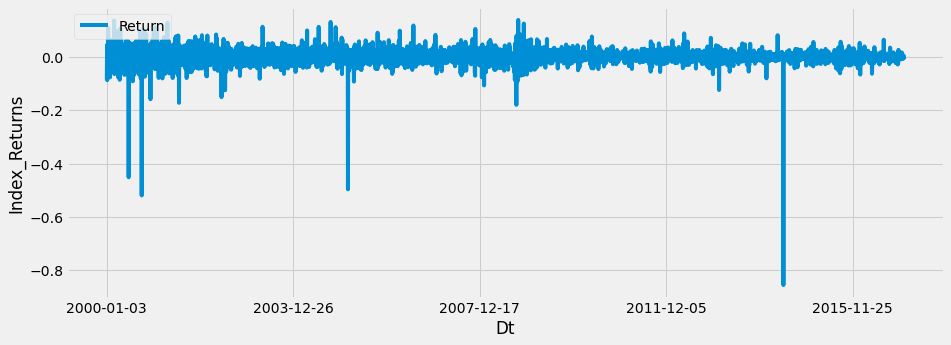

In [28]:
data['Return'].plot(figsize = (14,5))
plt.ylabel('Index_Returns')
plt.legend(loc = 2)

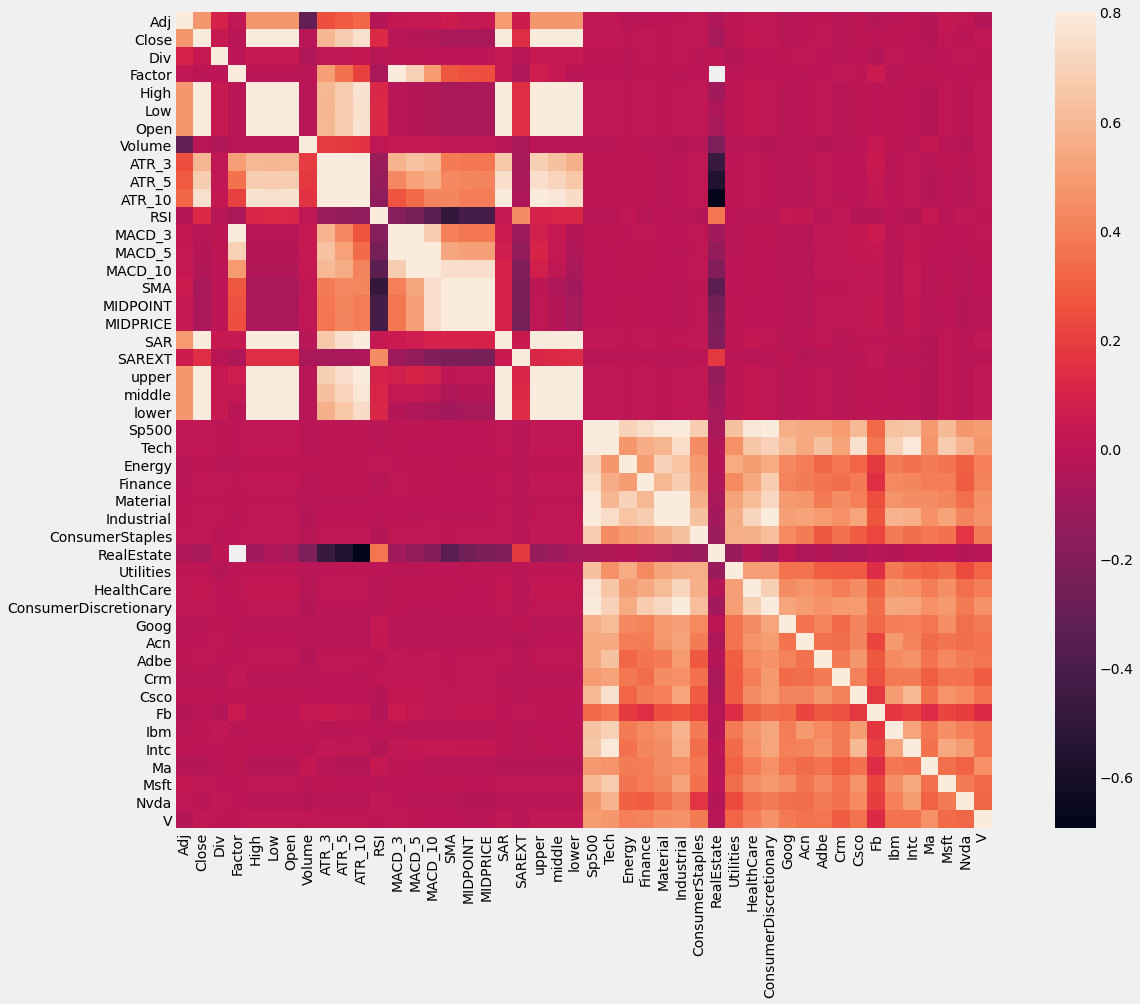

In [29]:
df1 = data.drop(columns = 'Return').copy()
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(corrmat, vmax=.8, square=True);

# Prepare the data

## Cleaning: handle missing data

## 1. Remove columns that has large percentage of NaNs

Text(0, 0.5, 'Percent of NaNs for Given Column')

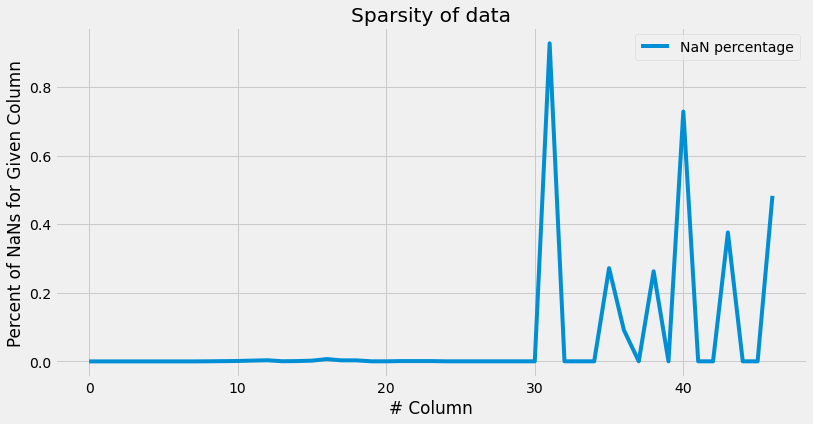

In [30]:
# check sparsity of column data
def check_sparsity_columns(df):
    sparsity = df.isna().mean() 
    return sparsity

column_sparsity = check_sparsity_columns(data)

plt.figure(figsize=(12,6))
plt.title('Sparsity of data')
plt.plot(column_sparsity.values, label='NaN percentage')
plt.legend()
plt.xlabel('# Column')
plt.ylabel('Percent of NaNs for Given Column')

In [31]:
# remove sparse columns
remove_threshold = 0.2
remove_columns = column_sparsity[column_sparsity>remove_threshold].index
print('Remove columns due to sparsity: {}'.format(remove_columns))

data = data.drop(columns=remove_columns)
print(data.describe())

Remove columns due to sparsity: Index(['RealEstate', 'Goog', 'Crm', 'Fb', 'Ma', 'V'], dtype='object')
               Adj        Close          Div       Factor         High  \
count  4277.000000  4277.000000  4277.000000  4277.000000  4277.000000   
mean     34.065846   170.450354     0.001999     1.001870   172.424040   
std      36.698987   173.484604     0.031011     0.094251   174.989551   
min       0.815400    13.120000     0.000000     1.000000    13.190000   
25%       3.115300    39.759000     0.000000     1.000000    40.260000   
50%      16.948300   106.745000     0.000000     1.000000   108.360000   
75%      62.413600   222.250000     0.000000     1.000000   224.980000   
max     122.771400   702.100000     0.570000     7.000000   705.070000   

               Low         Open        Volume       Return        ATR_3  ...  \
count  4277.000000  4277.000000  4.277000e+03  4276.000000  4274.000000  ...   
mean    168.407568   170.528689  1.299660e+08     0.000714     4.569216

## 2.Remove rows that has large percentage of NaNs

In [32]:
# check sparsity of row data and remove sparse rows
def check_sparsity_rows(df, remove_threshold=0.3):
    remove_row = list(df[df.isnull().mean(axis=1) > remove_threshold].index)
    keep_row = list(df[df.isnull().mean(axis=1) <= remove_threshold].index)

    print('Percent of Removed Rows: {}'.format(len(remove_row)/df.shape[0]))    
    return keep_row

keep_row = check_sparsity_rows(data, remove_threshold=0.3)
data = data.loc[keep_row, :]
print(data.describe())

Percent of Removed Rows: 0.0009352349777881693
               Adj        Close          Div       Factor         High  \
count  4273.000000  4273.000000  4273.000000  4273.000000  4273.000000   
mean     34.069527   170.508286     0.002001     1.001872   172.479927   
std      36.688409   173.555382     0.031026     0.094295   175.061895   
min       0.815400    13.120000     0.000000     1.000000    13.190000   
25%       3.111400    39.750000     0.000000     1.000000    39.990000   
50%      16.949600   106.745000     0.000000     1.000000   108.200000   
75%      62.413600   223.020000     0.000000     1.000000   225.000000   
max     122.771400   702.100000     0.570000     7.000000   705.070000   

               Low         Open        Volume       Return        ATR_3  ...  \
count  4273.000000  4273.000000  4.273000e+03  4273.000000  4273.000000  ...   
mean    168.466619   170.586864  1.299736e+08     0.000751     4.569965  ...   
std     172.004212   173.675039  9.973899e+07 

## 3.Imputation of missing values

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [34]:
univariate_columns = data.columns
   
imputer_uni = SimpleImputer(missing_values=np.nan, strategy='mean')
data[univariate_columns] = imputer_uni.fit_transform(data[univariate_columns])

In [35]:
imputer_multi = KNNImputer(n_neighbors=5, weights="uniform")

data[data.columns] = imputer_multi.fit_transform(data[data.columns])
data.head()

,Adj,Close,Div,Factor,High,Low,Open,Volume,Return,ATR_3,...,Utilities,HealthCare,ConsumerDiscretionary,Acn,Adbe,Csco,Ibm,Intc,Msft,Nvda
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.00,106.1183,191993200.0,0.047368,10.271000,...,0.008587,0.012195,0.047108,0.000722,0.048583,0.058750,-0.004386,0.041270,0.013073,0.016680
2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.50,96.5000,115183600.0,-0.017588,8.847333,...,0.003420,0.102259,-0.005137,0.000722,0.038610,0.037195,0.039648,0.045732,0.007287,0.032836
2000-01-10,3.0376,97.750,0.0,1.0,102.2500,94.75,102.0000,126266000.0,-0.051151,8.398222,...,-0.010769,-0.026641,-0.005657,0.000722,-0.068773,-0.030169,0.008475,0.045924,-0.025612,-0.040462
2000-01-11,2.8822,92.750,0.0,1.0,99.3750,90.50,95.9380,110387200.0,-0.059968,8.557148,...,-0.010300,-0.016610,-0.005656,0.000722,-0.004982,-0.025230,0.004202,0.017416,-0.032567,-0.025590
2000-01-12,2.7094,87.188,0.0,1.0,95.5012,86.50,95.0000,244017200.0,0.109671,8.705165,...,-0.009259,0.029805,0.005189,0.000722,0.053151,0.022878,-0.010460,-0.002060,0.018901,0.041718


## Find meaningful features

### There are 40 features in dataframe.However, they are not all useful. Some are not related to AAPL, some have a lot in common so that we do not need all of them. Therefore, we use linear regression to find their relationship. 

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

col = data.columns
col = col.drop('Return')
y = data['Return']
feature_list = []

for i in col:
    X=data[i]
    model = sm.OLS(y,X)
    results = model.fit()

    if (results.pvalues[0] <= 0.05):
        feature_list.append(i)
    else:
        print(results.pvalues[0],i)

0.8288097085189672 Adj
0.9667868791504289 Close
0.7174787696717108 Div
0.12157777242183991 Factor
0.9480052128724153 High
0.9588152699546647 Low
0.9526858939446521 Open
0.1637387420449488 Volume
0.9795469730658167 ATR_3
0.946839268095104 ATR_5
0.9405259644691113 ATR_10
0.15627663541062217 RSI
0.11489444550944457 MACD_3
0.12292031769511635 MACD_5
0.14888957898747712 MACD_10
0.15988728970609048 SMA
0.13739224918500775 MIDPOINT
0.1336960819009158 MIDPRICE
0.9449334270573914 SAR
0.2893771883354037 SAREXT
0.9682365140774181 upper
0.9573572181564127 middle
0.945979870709705 lower


In [37]:
print(len(feature_list),'\n',feature_list)

17 
 ['Sp500', 'Tech', 'Energy', 'Finance', 'Material', 'Industrial', 'ConsumerStaples', 'Utilities', 'HealthCare', 'ConsumerDiscretionary', 'Acn', 'Adbe', 'Csco', 'Ibm', 'Intc', 'Msft', 'Nvda']


In [38]:
feature_list.append('Factor')
feature_list.append('MACD_3')
feature_list.append('MACD_5')

In [39]:
# initialize raw data
X = data[feature_list]
y = data['Return']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

## PCA to reduce feature dimension

### Except for correlation, PCA can also be used to find effective features. Since we already know that there are not enough features, we only use PCA to double check. 

In [41]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()

20 has a cumulative explained variane of: 0.9993082867901358


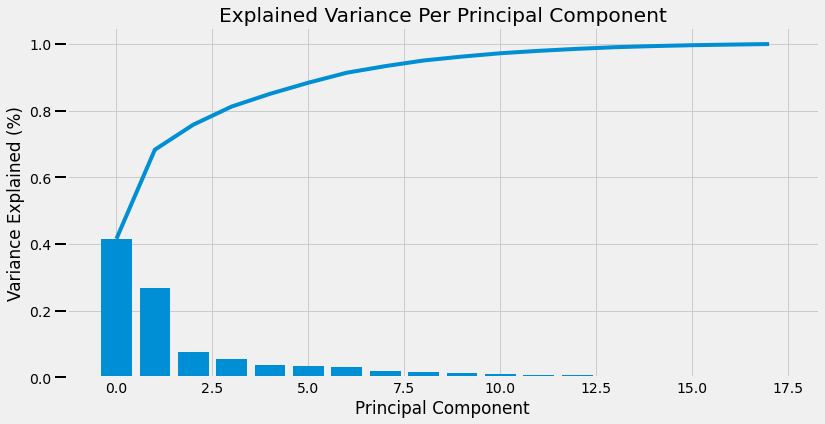

In [42]:
from sklearn.decomposition import PCA

def scree_plot(pca_estimator):

    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca = PCA(n_components = .999)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
scree_plot(pca)

n_components = 20
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

### The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 2 components.

### Then we will have a look at the components for each principle component.

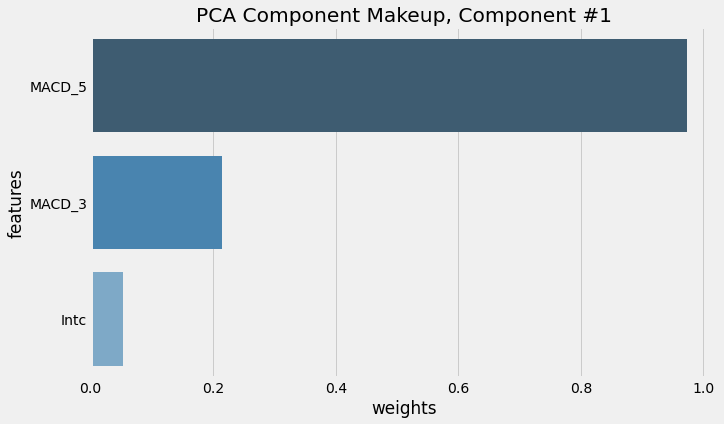

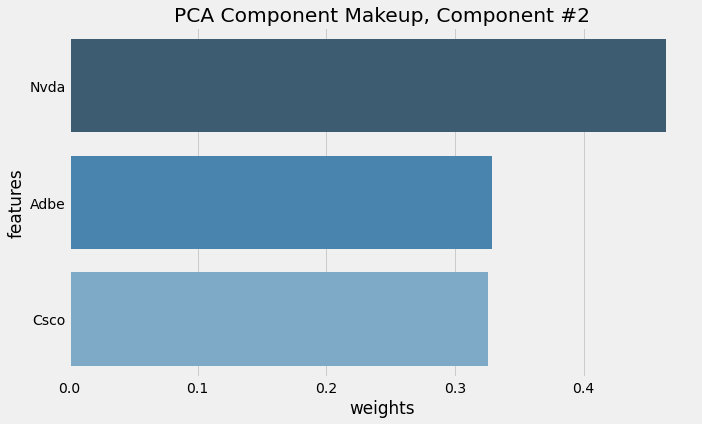

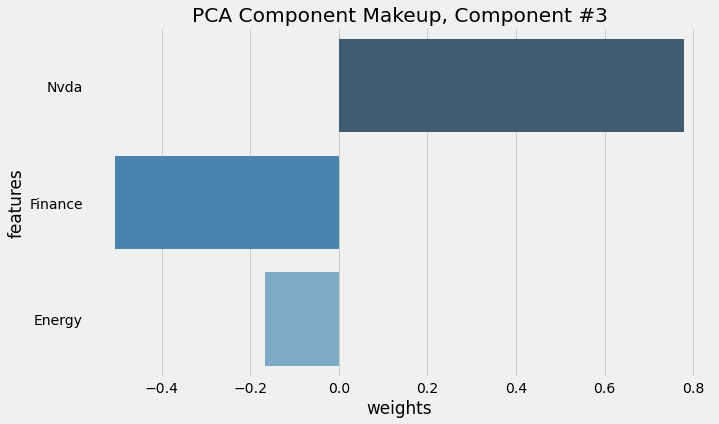

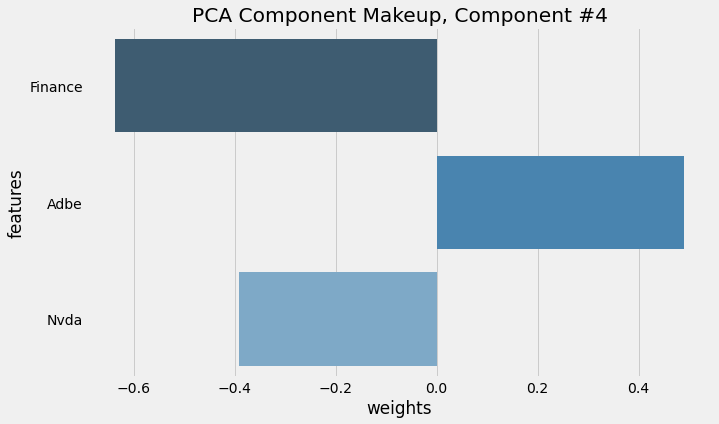

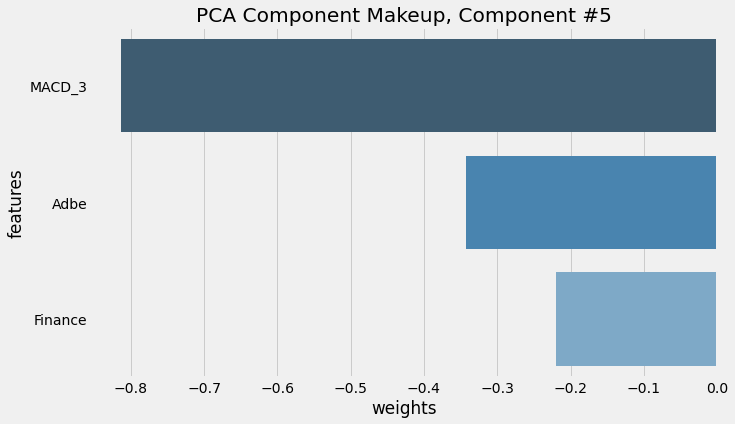

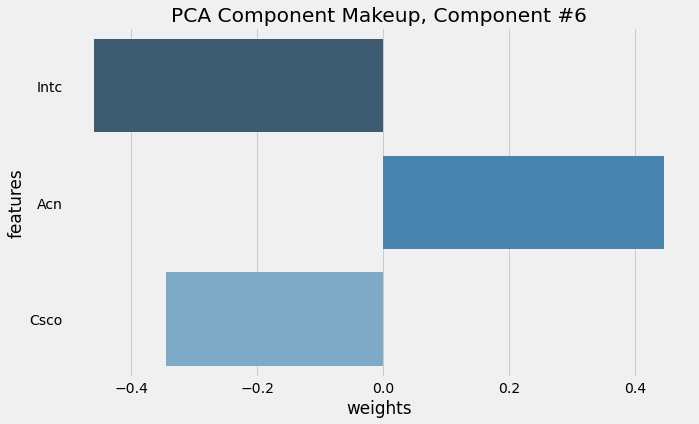

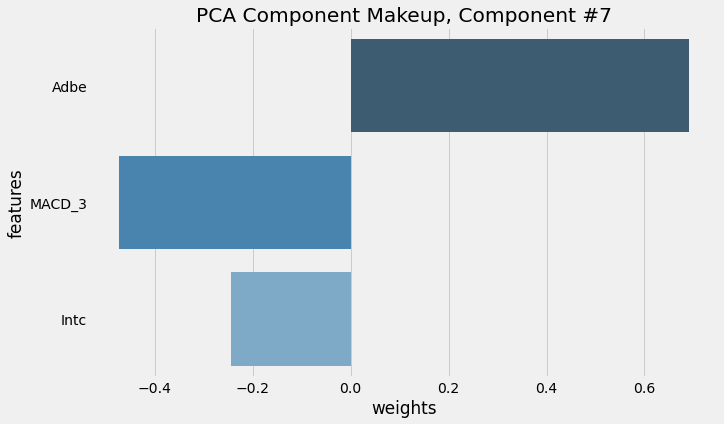

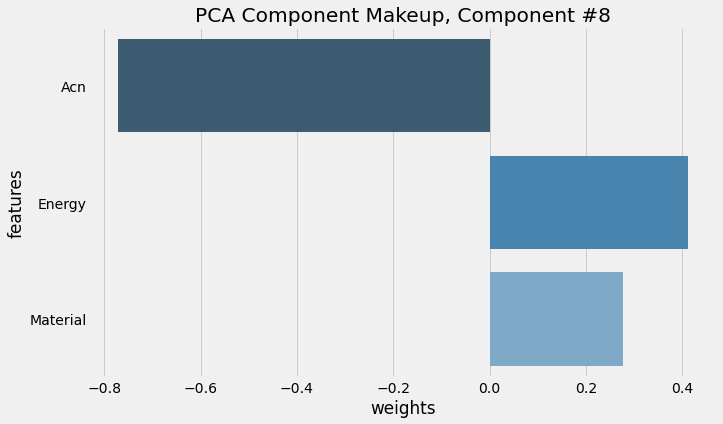

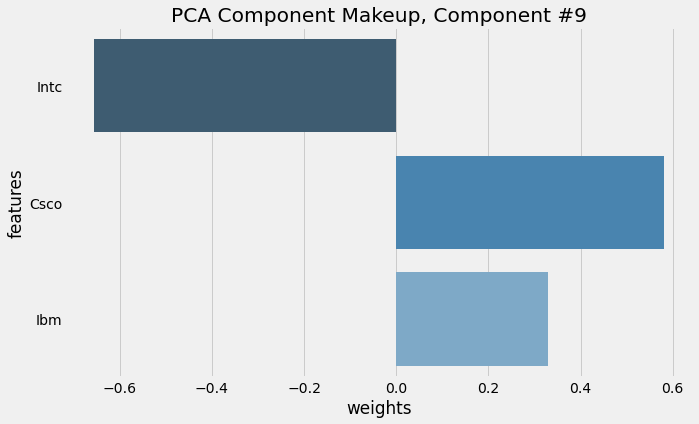

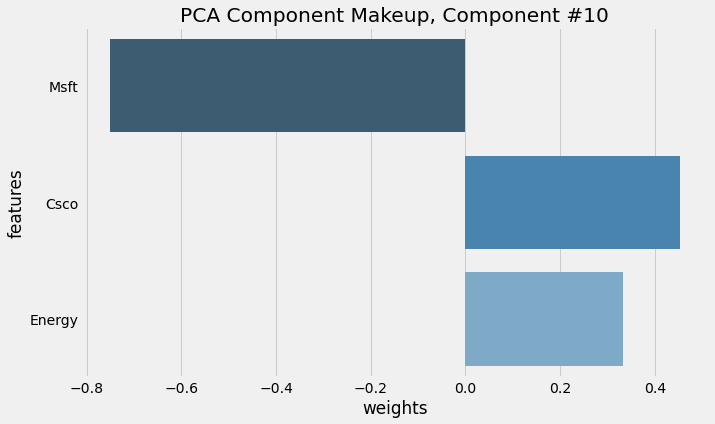

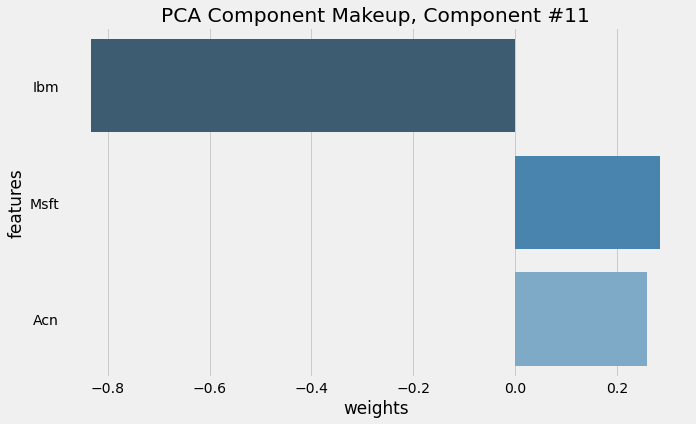

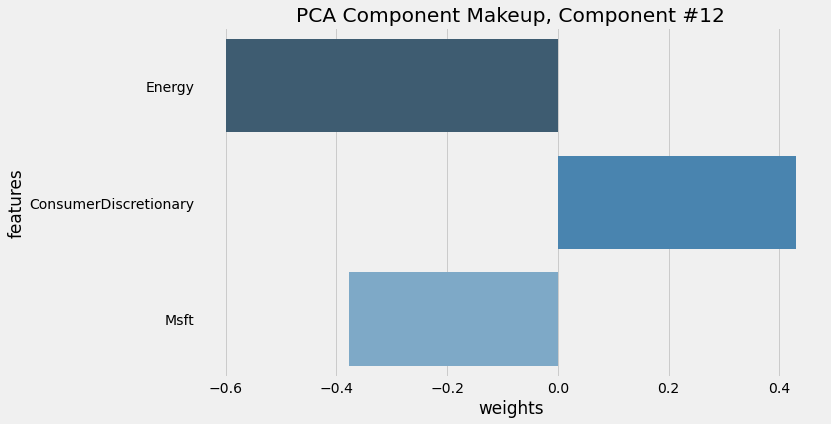

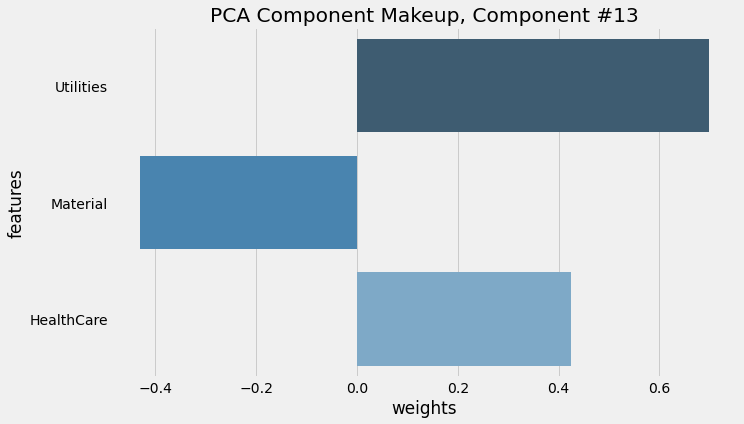

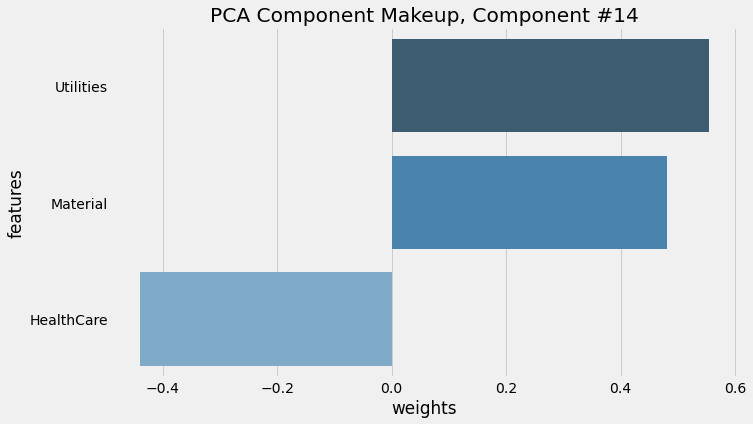

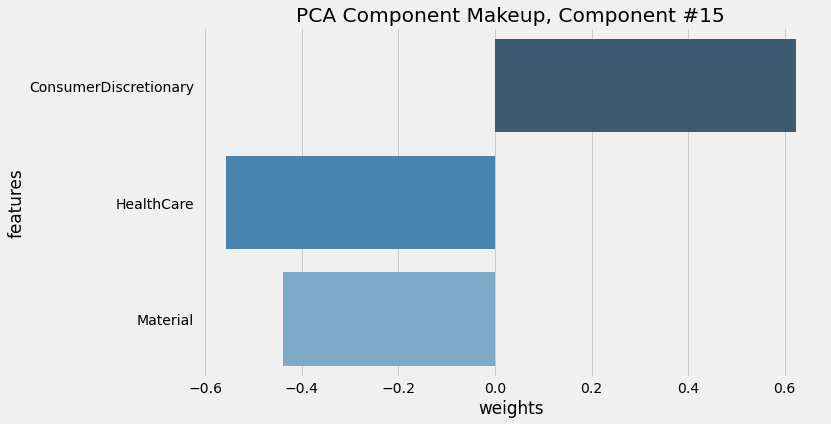

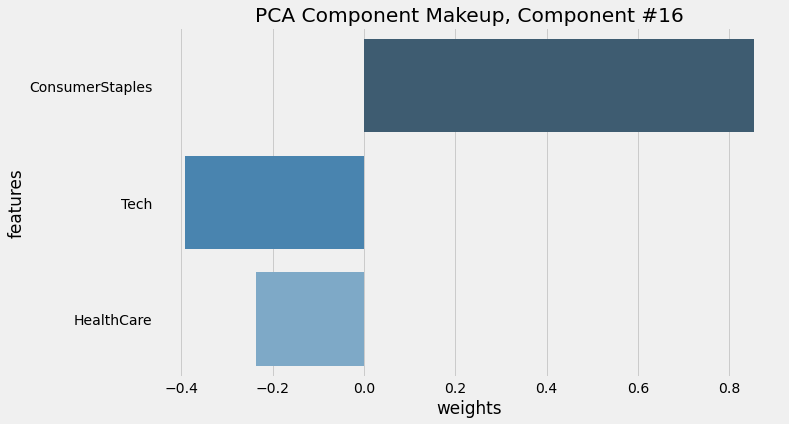

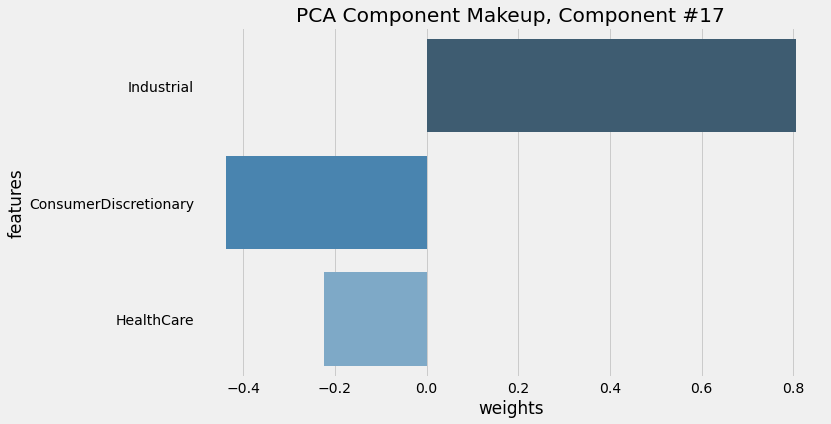

In [43]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = component_num - 1

    # get the list of weights from a row in v, dataframe
    v_1_row = v[row_idx]
    v_1 = np.squeeze(v_1_row)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

for num in range (1,18):
    display_component(pca.components_, X_train.columns.values, component_num=num, n_weights=3)

# Model training

### We will test the model with the measument R^2, MSE, MAE, and RMSE.

In [44]:
from sklearn.model_selection import train_test_split

## Model 1: LSTM with single layer

In [45]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train),5):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val[:m])
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val[:m]))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)

In [46]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real AAPL return")
    plt.plot(predicted, color="blue", label="predicted return")
    plt.title("AAPL stock price prediction")
    plt.xlabel("time")
    plt.ylabel("AAPL stock price")
    plt.legend()
    plt.show()

In [47]:
df = X.join(y)
df.describe()

,Sp500,Tech,Energy,Finance,Material,Industrial,ConsumerStaples,Utilities,HealthCare,ConsumerDiscretionary,...,Adbe,Csco,Ibm,Intc,Msft,Nvda,Factor,MACD_3,MACD_5,Return
count,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,...,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000,4273.000000
mean,0.000192,0.000127,0.000390,0.000156,0.000262,0.000278,0.000235,0.000209,0.000266,0.000343,...,0.000618,0.000081,0.000226,0.000272,0.000104,0.001190,1.001872,1.001417,1.002808,0.000751
std,0.012530,0.016523,0.017695,0.021719,0.015718,0.013662,0.009460,0.012113,0.011549,0.014359,...,0.030572,0.026521,0.016597,0.024075,0.021132,0.042551,0.094295,0.072225,0.105894,0.031431
min,-0.098448,-0.086538,-0.144438,-0.460298,-0.124121,-0.094050,-0.060241,-0.085285,-0.097826,-0.116249,...,-0.500695,-0.461035,-0.155416,-0.220317,-0.483230,-0.570623,1.000000,0.893079,0.861146,-0.854857
25%,-0.005333,-0.006987,-0.008363,-0.007190,-0.007533,-0.006143,-0.004709,-0.005583,-0.005384,-0.006388,...,-0.011717,-0.010309,-0.007345,-0.010865,-0.008667,-0.016629,1.000000,0.989712,0.983607,-0.011326
50%,0.000558,0.000759,0.000688,0.000422,0.000716,0.000662,0.000442,0.000756,0.000399,0.000593,...,0.000444,0.000256,0.000133,0.000382,0.000000,0.000582,1.000000,0.998928,0.997734,0.000755
75%,0.005929,0.007293,0.009873,0.007933,0.008483,0.007021,0.005258,0.006629,0.006293,0.007479,...,0.012622,0.011053,0.007910,0.011409,0.008946,0.017333,1.000000,1.008646,1.012497,0.013781
max,0.145198,0.161017,0.164747,0.224715,0.140576,0.107052,0.068857,0.120730,0.120547,0.097752,...,0.239740,0.243884,0.120232,0.201229,0.195652,0.424154,7.000000,4.932835,5.696862,0.139050


In [48]:
values=df.values
# make sure all data type is float
values=values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [91]:
print(scaled)

[[0.01752025 0.11884235 0.         ... 0.62054224 0.73105864 0.5903862 ]
 [0.01866739 0.12537374 0.         ... 0.63112676 0.72253556 0.60662723]
 [0.01822133 0.12283375 0.         ... 0.63158339 0.67407495 0.53294411]
 ...
 [0.91179442 0.15115098 0.         ... 0.49448427 0.70505186 0.50447159]
 [0.90787825 0.15042527 0.         ... 0.52458401 0.70969774 0.59367801]
 [0.90764292 0.15038172 0.         ... 0.4974048  0.69400448 0.53130879]]


In [92]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1],1))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


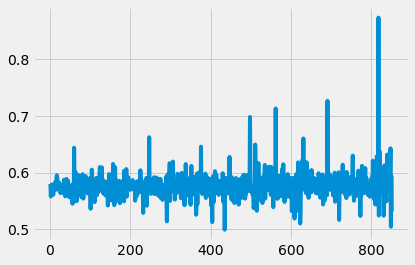

In [93]:
plt.plot(test_y)

Epoch 1/100
107/107 - 3s - loss: 0.0837
Epoch 2/100
107/107 - 3s - loss: 0.0466
Epoch 3/100
107/107 - 3s - loss: 0.0439
Epoch 4/100
107/107 - 3s - loss: 0.0402
Epoch 5/100
107/107 - 3s - loss: 0.0397
Epoch 6/100
107/107 - 3s - loss: 0.0386
Epoch 7/100
107/107 - 3s - loss: 0.0372
Epoch 8/100
107/107 - 3s - loss: 0.0360
Epoch 9/100
107/107 - 3s - loss: 0.0356
Epoch 10/100
107/107 - 3s - loss: 0.0347
Epoch 11/100
107/107 - 3s - loss: 0.0344
Epoch 12/100
107/107 - 3s - loss: 0.0338
Epoch 13/100
107/107 - 3s - loss: 0.0334
Epoch 14/100
107/107 - 3s - loss: 0.0321
Epoch 15/100
107/107 - 3s - loss: 0.0323
Epoch 16/100
107/107 - 3s - loss: 0.0316
Epoch 17/100
107/107 - 3s - loss: 0.0305
Epoch 18/100
107/107 - 3s - loss: 0.0305
Epoch 19/100
107/107 - 3s - loss: 0.0299
Epoch 20/100
107/107 - 3s - loss: 0.0292
Epoch 21/100
107/107 - 3s - loss: 0.0291
Epoch 22/100
107/107 - 3s - loss: 0.0283
Epoch 23/100
107/107 - 3s - loss: 0.0283
Epoch 24/100
107/107 - 3s - loss: 0.0276
Epoch 25/100
107/107 - 3s

KeyError: 'val_loss'

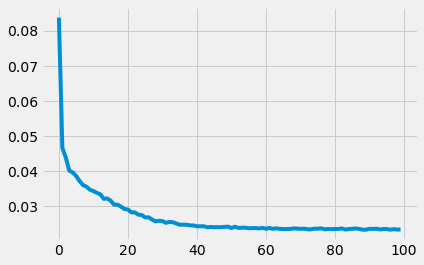

In [94]:
model1 = Sequential()
model1.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='relu'))
model1.compile(loss='mae', optimizer='adam')

# fit network
history = model1.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(X_test, y_test),verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

## Error analysis - Learning curve

In [ ]:
plot_learning_curves(model1, test_X, test_y)
plt.show()

In [95]:
y_insample = model1.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
print(train_X)

[[0.01752025 0.11884235 0.         ... 0.54790877 0.62054224 0.73105864]
 [0.01866739 0.12537374 0.         ... 0.70765431 0.63112676 0.72253556]
 [0.01822133 0.12283375 0.         ... 0.59456443 0.63158339 0.67407495]
 ...
 [0.4764456  0.65007693 0.76438596 ... 0.56169679 0.52898117 0.70329305]
 [0.46957099 0.6405556  0.         ... 0.58835077 0.53634123 0.71946023]
 [0.48310046 0.65929345 0.         ... 0.55096585 0.51006757 0.68312193]]


In [96]:
# invert scaling for forecast
inv_y_test = np.concatenate((train_X,y_insample), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_X,train_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('invert scaling for forecast：',inv_y_predict)
print('invert scaling for actual：',inv_y)

invert scaling for forecast： [0.02832608 0.03709781 0.00587325 ... 0.00553433 0.01200169 0.00340214]
invert scaling for actual： [ 0.01667962  0.03283582 -0.04046243 ... -0.01421865 -0.00828157
  0.00347947]


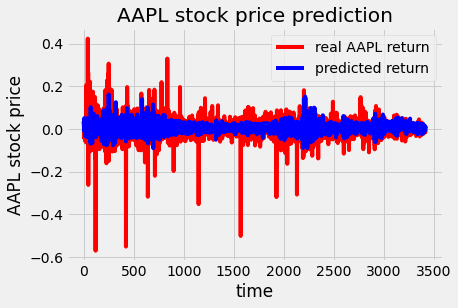

In [97]:
plot_predictions(inv_y, inv_y_predict)

In [98]:
import math
from sklearn.metrics import mean_absolute_error,r2_score
# calculate MSE 
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE : %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 0.001503
RMSE: 0.038771
MAE : 0.023621
R_square: 0.296719


In [99]:
y_predict = model1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
print(test_X)

[[0.51573436 0.7044907  0.         ... 0.5301595  0.4658845  0.6863036 ]
 [0.51511611 0.70363436 0.         ... 0.55503334 0.50971941 0.71226574]
 [0.51974811 0.71004964 0.         ... 0.54209328 0.56270145 0.6929497 ]
 ...
 [0.91179442 0.15115098 0.         ... 0.54320025 0.49448427 0.70505186]
 [0.90787825 0.15042527 0.         ... 0.57277026 0.52458401 0.70969774]
 [0.90764292 0.15038172 0.         ... 0.55053712 0.4974048  0.69400448]]


In [100]:
# invert scaling for forecast
inv_y_test = np.concatenate((test_X,y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('invert scaling for forecast：',inv_y_predict)
print('invert scaling for actual：',inv_y)

invert scaling for forecast： [-1.81991821e-02  2.34399190e-03  3.83521855e-03  1.43568158e-02
  2.97760017e-03  1.76311107e-02  1.74079307e-02  2.39557707e-03
 -1.02171172e-02  9.28901688e-03  9.26043750e-03  2.96562292e-03
  1.34927937e-02  1.67062537e-02  1.13071831e-02  3.90186423e-03
  2.36988913e-02  1.99560013e-02  1.79993815e-02  1.30131910e-03
  2.07525476e-02  1.18485310e-02  9.80457218e-03  2.84637606e-02
  3.50282028e-03 -6.60823009e-03  2.06021413e-03  9.15556853e-04
  9.92458183e-03  3.38648681e-03 -1.00331893e-02  4.17374492e-04
  1.09642900e-02  4.18487118e-03 -4.49383078e-03  1.38518147e-02
 -4.70811679e-03 -1.54217650e-02  1.19508713e-02  3.54183911e-02
  2.04596386e-02  1.41835014e-02 -2.84808577e-03  1.86417059e-02
 -1.54292360e-02  1.08362164e-02  1.02278078e-02  1.02844329e-02
 -1.99669318e-03  1.71525545e-02  1.76299249e-02  1.14185360e-02
  2.61627060e-02 -2.11588020e-05  3.18251784e-03  6.19787893e-03
  1.43762640e-02  4.14081625e-03  2.26089024e-02  6.35692446e

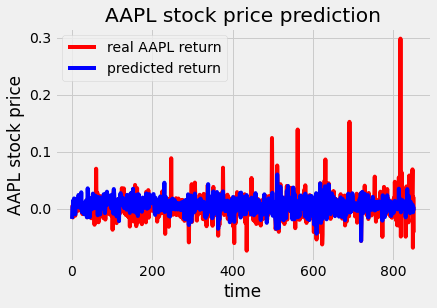

In [101]:
plot_predictions(inv_y, inv_y_predict)

In [102]:
import math
from sklearn.metrics import mean_absolute_error,r2_score

# calculate MSE 
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE : %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 0.000411
RMSE: 0.020270
MAE : 0.012341
R_square: 0.168897


### Model 1 has low insample and outsample performance. Possible solution for that is to increase epoch size. The dropout layer may not be necessary at this time. 

### The out-of-sample test performance is still low. We try adjust settings.

In [103]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


#### 1. Increase epochs size to double

Epoch 1/500
107/107 - 5s - loss: 0.0624 - val_loss: 0.0134
Epoch 2/500
107/107 - 3s - loss: 0.0246 - val_loss: 0.0128
Epoch 3/500
107/107 - 3s - loss: 0.0242 - val_loss: 0.0124
Epoch 4/500
107/107 - 3s - loss: 0.0244 - val_loss: 0.0128
Epoch 5/500
107/107 - 3s - loss: 0.0243 - val_loss: 0.0120
Epoch 6/500
107/107 - 3s - loss: 0.0243 - val_loss: 0.0123
Epoch 7/500
107/107 - 3s - loss: 0.0243 - val_loss: 0.0121
Epoch 8/500
107/107 - 3s - loss: 0.0242 - val_loss: 0.0119
Epoch 9/500
107/107 - 3s - loss: 0.0240 - val_loss: 0.0118
Epoch 10/500
107/107 - 3s - loss: 0.0241 - val_loss: 0.0117
Epoch 11/500
107/107 - 3s - loss: 0.0242 - val_loss: 0.0118
Epoch 12/500
107/107 - 3s - loss: 0.0242 - val_loss: 0.0118
Epoch 13/500
107/107 - 3s - loss: 0.0241 - val_loss: 0.0116
Epoch 14/500
107/107 - 3s - loss: 0.0242 - val_loss: 0.0117
Epoch 15/500
107/107 - 3s - loss: 0.0243 - val_loss: 0.0120
Epoch 16/500
107/107 - 3s - loss: 0.0239 - val_loss: 0.0119
Epoch 17/500
107/107 - 3s - loss: 0.0243 - val_lo

107/107 - 3s - loss: 0.0229 - val_loss: 0.0133
Epoch 138/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0134
Epoch 139/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0137
Epoch 140/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0135
Epoch 141/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0133
Epoch 142/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0132
Epoch 143/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0135
Epoch 144/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0132
Epoch 145/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0137
Epoch 146/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0133
Epoch 147/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0136
Epoch 148/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0133
Epoch 149/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0140
Epoch 150/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0133
Epoch 151/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0133
Epoch 152/500
107/107 - 3s - loss: 0.0230 - val_loss: 0.0134
Epoch 153/500
107/107 - 3s - loss: 0.0

Epoch 272/500
107/107 - 3s - loss: 0.0239 - val_loss: 0.0260
Epoch 273/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0275
Epoch 274/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0270
Epoch 275/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0262
Epoch 276/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0262
Epoch 277/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0260
Epoch 278/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0260
Epoch 279/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0260
Epoch 280/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0281
Epoch 281/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0280
Epoch 282/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0266
Epoch 283/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0259
Epoch 284/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0262
Epoch 285/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0275
Epoch 286/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0283
Epoch 287/500
107/107 - 3s - loss: 0.0240 - val_loss: 0.0269
Epoch 288/500
107/107 - 

Epoch 407/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0217
Epoch 408/500
107/107 - 3s - loss: 0.0228 - val_loss: 0.0194
Epoch 409/500
107/107 - 3s - loss: 0.0227 - val_loss: 0.0181
Epoch 410/500
107/107 - 3s - loss: 0.0237 - val_loss: 0.0279
Epoch 411/500
107/107 - 3s - loss: 0.0248 - val_loss: 0.0348
Epoch 412/500
107/107 - 3s - loss: 0.0236 - val_loss: 0.0225
Epoch 413/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0222
Epoch 414/500
107/107 - 3s - loss: 0.0228 - val_loss: 0.0198
Epoch 415/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0251
Epoch 416/500
107/107 - 3s - loss: 0.0251 - val_loss: 0.0415
Epoch 417/500
107/107 - 3s - loss: 0.0238 - val_loss: 0.0215
Epoch 418/500
107/107 - 3s - loss: 0.0228 - val_loss: 0.0208
Epoch 419/500
107/107 - 3s - loss: 0.0229 - val_loss: 0.0235
Epoch 420/500
107/107 - 3s - loss: 0.0241 - val_loss: 0.0251
Epoch 421/500
107/107 - 3s - loss: 0.0265 - val_loss: 0.0297
Epoch 422/500
107/107 - 3s - loss: 0.0236 - val_loss: 0.0317
Epoch 423/500
107/107 - 

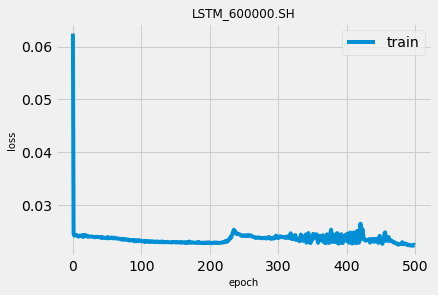

In [105]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation='relu'))
model3.compile(loss='mae', optimizer='adam')
# fit network
history = model3.fit(X_train, y_train, epochs=500, batch_size=32,validation_data=(X_test, y_test), verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [106]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

y_predict3 = model3.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_y_test3 = np.concatenate((X_test,y_predict3), axis=1)
inv_y_test3 = scaler.inverse_transform(inv_y_test3)
inv_y_predict3=inv_y_test3[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train3 = np.concatenate((X_test,y_test), axis=1)
inv_y_train3 = scaler.inverse_transform(inv_y_train3)
inv_y3 = inv_y_train3[:, -1]

mse3=mean_squared_error(inv_y3,inv_y_predict3)
rmse3 = math.sqrt(mean_squared_error(inv_y3, inv_y_predict3))
mae3=mean_absolute_error(inv_y3,inv_y_predict3)
r_square3=r2_score(inv_y3,inv_y_predict3)

print('MSE: %.6f' % mse3)
print('RMSE: %.6f' % rmse3)
print('MAE: %.6f' % mae3)
print('R_square: %.6f' % r_square3)

MSE: 0.000517
RMSE: 0.022739
MAE: 0.016008
R_square: -0.045888


#### 2. Increase batch size to double

In [110]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


Epoch 1/100
54/54 - 2s - loss: 0.0762 - val_loss: 0.0165
Epoch 2/100
54/54 - 2s - loss: 0.0254 - val_loss: 0.0150
Epoch 3/100
54/54 - 2s - loss: 0.0246 - val_loss: 0.0140
Epoch 4/100
54/54 - 2s - loss: 0.0244 - val_loss: 0.0136
Epoch 5/100
54/54 - 2s - loss: 0.0241 - val_loss: 0.0132
Epoch 6/100
54/54 - 2s - loss: 0.0240 - val_loss: 0.0130
Epoch 7/100
54/54 - 2s - loss: 0.0239 - val_loss: 0.0129
Epoch 8/100
54/54 - 2s - loss: 0.0239 - val_loss: 0.0129
Epoch 9/100
54/54 - 2s - loss: 0.0241 - val_loss: 0.0124
Epoch 10/100
54/54 - 2s - loss: 0.0238 - val_loss: 0.0124
Epoch 11/100
54/54 - 2s - loss: 0.0237 - val_loss: 0.0122
Epoch 12/100
54/54 - 2s - loss: 0.0237 - val_loss: 0.0123
Epoch 13/100
54/54 - 2s - loss: 0.0237 - val_loss: 0.0123
Epoch 14/100
54/54 - 2s - loss: 0.0238 - val_loss: 0.0121
Epoch 15/100
54/54 - 2s - loss: 0.0236 - val_loss: 0.0121
Epoch 16/100
54/54 - 2s - loss: 0.0238 - val_loss: 0.0120
Epoch 17/100
54/54 - 2s - loss: 0.0238 - val_loss: 0.0120
Epoch 18/100
54/54 - 2s

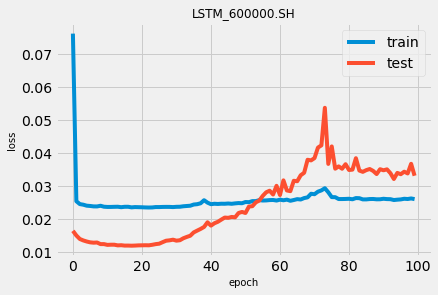

In [111]:
model4 = Sequential()
model4.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dropout(0.5))
model4.add(Dense(1,activation='relu'))
model4.compile(loss='mae', optimizer='adam')
# fit network
history = model4.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [114]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

y_predict4 = model4.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_y_test4 = np.concatenate((X_test,y_predict4), axis=1)
inv_y_test4 = scaler.inverse_transform(inv_y_test4)
inv_y_predict4=inv_y_test4[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train4 = np.concatenate((X_test,y_test), axis=1)
inv_y_train4 = scaler.inverse_transform(inv_y_train4)
inv_y4 = inv_y_train4[:, -1]

mse4=mean_squared_error(inv_y4,inv_y_predict4)
rmse4 = math.sqrt(mean_squared_error(inv_y4, inv_y_predict4))
mae4=mean_absolute_error(inv_y4,inv_y_predict4)
r_square4=r2_score(inv_y4,inv_y_predict4)
print('MSE: %.6f' % mse4)
print('RMSE: %.6f' % rmse4)
print('MAE: %.6f' % mae4)
print('R_square: %.6f' % r_square4)

MSE: 0.001560
RMSE: 0.039492
MAE: 0.032989
R_square: -2.154797


#### 3. Change activation method

In [117]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


Epoch 1/10
107/107 - 5s - loss: 0.4255 - val_loss: 0.4238
Epoch 2/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 3/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 4/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 5/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 6/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 7/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 8/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 9/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238
Epoch 10/10
107/107 - 3s - loss: 0.4255 - val_loss: 0.4238


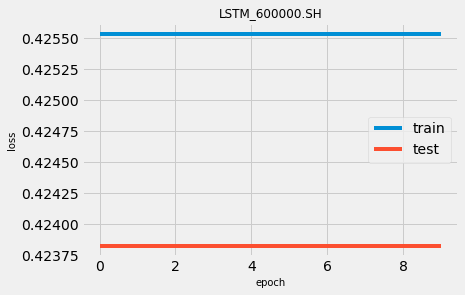

In [121]:
model5 = Sequential()
model5.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model5.add(Dense(1,activation='softmax'))
model5.compile(loss='mae', optimizer='adam')
# fit network
history = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [122]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

y_predict5 = model5.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_y_test5 = np.concatenate((X_test,y_predict5), axis=1)
inv_y_test5 = scaler.inverse_transform(inv_y_test5)
inv_y_predict5=inv_y_test5[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train5 = np.concatenate((X_test,y_test), axis=1)
inv_y_train5 = scaler.inverse_transform(inv_y_train5)
inv_y5 = inv_y_train5[:, -1]

mse5=mean_squared_error(inv_y5,inv_y_predict5)
rmse5 = math.sqrt(mean_squared_error(inv_y5, inv_y_predict5))
mae5=mean_absolute_error(inv_y5,inv_y_predict5)
r_square5=r2_score(inv_y5,inv_y_predict5)
print('MSE: %.6f' % mse5)
print('RMSE: %.6f' % rmse5)
print('MAE: %.6f' % mae5)
print('R_square: %.6f' % r_square5)

MSE: 0.178253
RMSE: 0.422201
MAE: 0.421615
R_square: -359.577507


In [123]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


Epoch 1/100
107/107 - 4s - loss: 0.0565 - val_loss: 0.0123
Epoch 2/100
107/107 - 3s - loss: 0.0245 - val_loss: 0.0119
Epoch 3/100
107/107 - 3s - loss: 0.0249 - val_loss: 0.0118
Epoch 4/100
107/107 - 3s - loss: 0.0250 - val_loss: 0.0122
Epoch 5/100
107/107 - 3s - loss: 0.0249 - val_loss: 0.0139
Epoch 6/100
107/107 - 3s - loss: 0.0246 - val_loss: 0.0129
Epoch 7/100
107/107 - 3s - loss: 0.0244 - val_loss: 0.0126
Epoch 8/100
107/107 - 3s - loss: 0.0243 - val_loss: 0.0130
Epoch 9/100
107/107 - 3s - loss: 0.0244 - val_loss: 0.0133
Epoch 10/100
107/107 - 3s - loss: 0.0242 - val_loss: 0.0131
Epoch 11/100
107/107 - 3s - loss: 0.0242 - val_loss: 0.0132
Epoch 12/100
107/107 - 3s - loss: 0.0241 - val_loss: 0.0133
Epoch 13/100
107/107 - 3s - loss: 0.0241 - val_loss: 0.0129
Epoch 14/100
107/107 - 3s - loss: 0.0241 - val_loss: 0.0132
Epoch 15/100
107/107 - 3s - loss: 0.0240 - val_loss: 0.0128
Epoch 16/100
107/107 - 3s - loss: 0.0241 - val_loss: 0.0126
Epoch 17/100
107/107 - 3s - loss: 0.0240 - val_lo

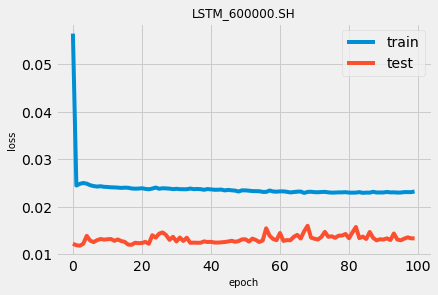

In [124]:
model6 = Sequential()
model6.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model6.add(Dense(1,activation='tanh'))
model6.compile(loss='mae', optimizer='adam')
# fit network
history = model6.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [125]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

y_predict6 = model6.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_y_test6 = np.concatenate((X_test,y_predict6), axis=1)
inv_y_test6 = scaler.inverse_transform(inv_y_test6)
inv_y_predict6=inv_y_test6[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train6 = np.concatenate((X_test,y_test), axis=1)
inv_y_train6 = scaler.inverse_transform(inv_y_train6)
inv_y6 = inv_y_train6[:, -1]

mse6=mean_squared_error(inv_y6,inv_y_predict6)
rmse6 = math.sqrt(mean_squared_error(inv_y6, inv_y_predict6))
mae6=mean_absolute_error(inv_y6,inv_y_predict6)
r_square6=r2_score(inv_y6,inv_y_predict6)
print('MSE: %.6f' % mse6)
print('RMSE: %.6f' % rmse6)
print('MAE: %.6f' % mae6)
print('R_square: %.6f' % r_square6)

MSE: 0.000467
RMSE: 0.021613
MAE: 0.013320
R_square: 0.055106


#### 4. Change optimizer

In [126]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


Epoch 1/10
54/54 - 3s - loss: 0.5745 - val_loss: 0.5762
Epoch 2/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 3/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 4/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 5/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 6/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 7/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 8/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 9/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762
Epoch 10/10
54/54 - 2s - loss: 0.5745 - val_loss: 0.5762


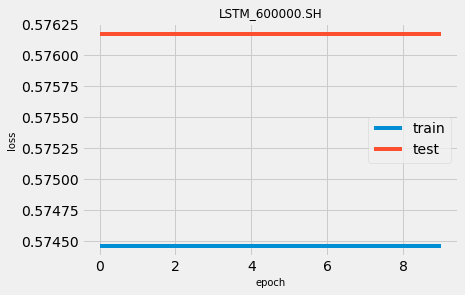

In [128]:
model7 = Sequential()
model7.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model7.add(Dense(1,activation='relu'))
model7.compile(loss='mae', optimizer='rmsprop')
# fit network
history = model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2,shuffle=False)
 
# plot loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_600000.SH', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [129]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

y_predict7 = model7.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_y_test7 = np.concatenate((X_test,y_predict7), axis=1)
inv_y_test7 = scaler.inverse_transform(inv_y_test7)
inv_y_predict7=inv_y_test7[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train7 = np.concatenate((X_test,y_test), axis=1)
inv_y_train7 = scaler.inverse_transform(inv_y_train7)
inv_y7 = inv_y_train7[:, -1]

mse7=mean_squared_error(inv_y7,inv_y_predict7)
rmse7 = math.sqrt(mean_squared_error(inv_y7, inv_y_predict7))
mae7=mean_absolute_error(inv_y7,inv_y_predict7)
r_square7=r2_score(inv_y7,inv_y_predict7)
print('MSE: %.6f' % mse7)
print('RMSE: %.6f' % rmse7)
print('MAE: %.6f' % mae7)
print('R_square: %.6f' % r_square7)

MSE: 0.329009
RMSE: 0.573593
MAE: 0.573162
R_square: -664.531234


## Model 2: LSTM with multiple layers

In [130]:
train = scaled[:3420, :]
test = scaled[3421:, :]

# split the train and test sets
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3420, 40, 1) (3420,)
(852, 40, 1) (852,)


In [135]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=50, return_sequences=True, activation = 'relu',input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.5))

# add second layer

regressor.add(GRU(units=50, return_sequences=True, activation = 'relu'))
regressor.add(Dropout(0.5))

# add fourth layer

regressor.add(LSTM(units=50, activation = 'relu'))
regressor.add(Dropout(0.5))

# the output layer

regressor.add(Dense(units=1))

In [139]:
# compiling the LSTM RNN network

regressor.compile(optimizer='adam', loss='mean_squared_error' )

# fit to the training set

regressor.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
107/107 [==============================] - 12s 115ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 2/50
107/107 [==============================] - 11s 102ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 3/50
107/107 [==============================] - 11s 103ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 4/50
107/107 [==============================] - 11s 103ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 5/50
107/107 [==============================] - 11s 102ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/50
107/107 [==============================] - 11s 103ms/step - loss: 0.0030 - val_loss: 5.5052e-04
Epoch 7/50
107/107 [==============================] - 11s 102ms/step - loss: 0.0025 - val_loss: 6.5539e-04
Epoch 8/50
107/107 [==============================] - 11s 103ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 9/50
107/107 [==============================] - 11s 102ms/step - loss: 0.0022 - val_loss: 5.4985e-04
Epoch 10/50
107/107 [==============================] - 11s 10

In [140]:
y_predict2 = regressor.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
print(X_test)

[[0.51573436 0.7044907  0.         ... 0.5301595  0.4658845  0.6863036 ]
 [0.51511611 0.70363436 0.         ... 0.55503334 0.50971941 0.71226574]
 [0.51974811 0.71004964 0.         ... 0.54209328 0.56270145 0.6929497 ]
 ...
 [0.91179442 0.15115098 0.         ... 0.54320025 0.49448427 0.70505186]
 [0.90787825 0.15042527 0.         ... 0.57277026 0.52458401 0.70969774]
 [0.90764292 0.15038172 0.         ... 0.55053712 0.4974048  0.69400448]]


In [141]:
# invert scaling for forecast
inv_y_test2 = np.concatenate((X_test,y_predict2), axis=1)
inv_y_test2 = scaler.inverse_transform(inv_y_test2)
inv_y_predict2=inv_y_test2[:,-1]
 
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_train2 = np.concatenate((X_test,y_test), axis=1)
inv_y_train2 = scaler.inverse_transform(inv_y_train2)
inv_y2 = inv_y_train2[:, -1]

print('invert scaling for forecast：',inv_y_predict2)
print('invert scaling for actual：',inv_y2)

invert scaling for forecast： [-2.49312848e-02 -1.93221973e-02 -1.74265903e-02 -9.40337585e-03
 -1.90061047e-02 -7.34738045e-03 -9.39110213e-03 -1.85718998e-02
 -2.33140006e-02 -1.49933709e-02 -1.25916955e-02 -1.84932769e-02
 -1.05546740e-02 -6.86093816e-03 -1.32941433e-02 -1.70424290e-02
 -3.52130197e-03 -4.04462469e-03 -5.79039752e-03 -1.89565355e-02
 -4.54411151e-03 -7.26780883e-03 -1.25334695e-02  1.02493906e-02
 -1.84893635e-02 -2.29779261e-02 -1.83382842e-02 -1.88466057e-02
 -1.51627719e-02 -1.61931117e-02 -2.22980691e-02 -1.92715608e-02
 -1.10989865e-02 -1.82233738e-02 -2.21171059e-02 -1.00103021e-02
 -2.24622522e-02 -2.39207490e-02 -1.31324505e-02  9.79686405e-03
 -4.17631513e-03 -1.05796958e-02 -2.19800791e-02 -4.80998269e-03
 -1.82820741e-02 -1.45319504e-02 -1.42816140e-02 -9.71946846e-03
 -1.93422977e-02 -7.86649335e-03 -8.85971552e-03 -1.19869038e-02
 -4.89990976e-04 -2.08287809e-02 -1.82086690e-02 -1.42318670e-02
 -1.14922790e-02 -1.68007495e-02 -4.32110938e-03 -2.14818374e

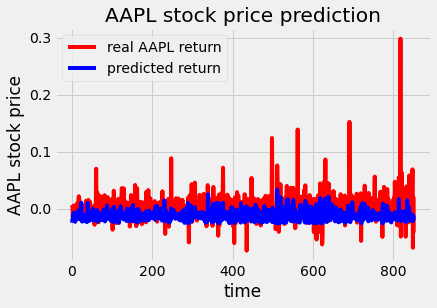

In [142]:
plot_predictions(inv_y2, inv_y_predict2)

In [143]:
# Out of sample performance 
# calculate MSE 
mse2=mean_squared_error(inv_y2,inv_y_predict2)
# calculate RMSE 
rmse2 = math.sqrt(mean_squared_error(inv_y2, inv_y_predict2))
#calculate MAE 
mae2 = mean_absolute_error(inv_y2,inv_y_predict2)
#calculate R square
r_square2 =r2_score(inv_y2,inv_y_predict2)
print('MSE: %.6f' % mse2)
print('RMSE: %.6f' % rmse2)
print('MAE: %.6f' % mae2)
print('R_square: %.6f' % r_square2)

MSE: 0.000633
RMSE: 0.025151
MAE: 0.017693
R_square: -0.279577


# Final Model

In [49]:
X = scaled[:,:-1]
y = scaled[:,-1]

X_all = X.reshape((X.shape[0], X.shape[1],1))

In [50]:
final_model = Sequential()
final_model.add(LSTM(units=50, return_sequences=True, activation = 'relu',input_shape=(X_train.shape[1],1)))
final_model.add(Dropout(0.2))
final_model.add(Dense(units=1))

In [51]:
final_model.compile(optimizer='adam', loss='mean_squared_error' )

final_model.fit(X_all, y,epochs = 100, batch_size=32)

Epoch 1/100
134/134 [==============================] - 3s 21ms/step - loss: 0.1651
Epoch 2/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0363
Epoch 3/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0204
Epoch 4/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0135: 0s - l
Epoch 5/100
134/134 [==============================] - 3s 22ms/step - loss: 0.0097
Epoch 6/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0077
Epoch 7/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0066: 1s - loss:
Epoch 8/100
134/134 [==============================] - 3s 20ms/step - loss: 0.0059
Epoch 9/100
134/134 [==============================] - 3s 20ms/step - loss: 0.0056: 2
Epoch 10/100
134/134 [==============================] - 3s 21ms/step - loss: 0.0052
Epoch 11/100
134/134 [==============================] - 3s 20ms/step - loss: 0.0050: 0s - loss: 0.00
Epoch 12/100
134/134 [=======================

134/134 [==============================] - 2s 18ms/step - loss: 8.1175e-04
Epoch 92/100
134/134 [==============================] - 2s 18ms/step - loss: 8.0452e-04
Epoch 93/100
134/134 [==============================] - 2s 18ms/step - loss: 8.0699e-04
Epoch 94/100
134/134 [==============================] - 2s 18ms/step - loss: 8.1616e-04
Epoch 95/100
134/134 [==============================] - 2s 18ms/step - loss: 8.0244e-04
Epoch 96/100
134/134 [==============================] - 2s 18ms/step - loss: 8.0170e-04
Epoch 97/100
134/134 [==============================] - 2s 18ms/step - loss: 7.9514e-04
Epoch 98/100
134/134 [==============================] - 2s 18ms/step - loss: 7.9975e-04
Epoch 99/100
134/134 [==============================] - ETA: 0s - loss: 7.9849e-0 - 2s 18ms/step - loss: 7.9625e-04
Epoch 100/100
134/134 [==============================] - 2s 18ms/step - loss: 7.9724e-04


# My Model

In [52]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []

    df = pd.read_csv(holdout_dir)
    df = df.apply(pd.to_numeric, errors = 'coerce')
    
    if 'Dt' in df:
        date = df['Dt']
        df.insert(1, date)
    # drop sparse feature
    remove_columns = column_sparsity[column_sparsity>remove_threshold].index
    df = df.drop(columns=remove_columns)
    
    df[univariate_columns] = final_imputer_uni.transform(df[univariate_columns])
    df[df.columns] = final_imputer_multi.transform(df[df.columns])
    values=df.values
    # make sure all data type is float
    values=values.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(values) 
    
    X = X.reshape((X.shape[0],X.shape[1],1))
    predictions = final_model.predict(X)
    ids = X[:,0][-200]
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = final_model

saveModel(my_model, model_path)

Directory .\final_model already exists, files will be over-written.
Model saved in directory .\final_model; create an archive of this directory and submit with your assignment.


## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will copy your model file to this directory with the name stored in `model_path`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [225]:
holdout_dir = os.path.join(".", "Data", "holdout", '5th_yr.csv')
predicts = MyModel(holdout_dir, model_path)

In [53]:
print("Done")

Done
